# Biodiversity Intactness Index (BII) Change in Phoenix, AZ 

**Author:** Megan Hessel 

**Github Repo:** https://github.com/meganhessel/biodiversity_Phoenix_AZ.git

## About 
**Purpose**

Studying how the urban spaw in Phoenix, AZ is disrubiting the biodiversity and ecosystem healthm, by comparing 2017 and 2020 land rasters 

**Highlights**

-  Pull information from catalogs 
-  Clip and mask rasters 
-  Manipulate rasters with logisticals 
-  Create multi-component professional plot 

**About the Data**

-  
-  The Phoenix, AZ border was 

**References**

In [ ]:
# Load libaries 
import os
import pandas as pd
import geopandas as gpd
import numpy as np

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

from IPython.display import Image  # To nicely display images
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## Find Phoenix, AZ 2017 and 2020 BBI measurements 

`Catalogs` carry lots of information! Inside the catalog, there are collections filled with items. Items have properties and assets. 

In the next couple of code chunks we will look into the catalogs and pull out collections and items. 

The **goal** is to find BII data measurements of 2017 and 2020 in Phoenix, AZ. 

First, we will look at all the collections in the catalog, and pull out the BII collection. 

In [ ]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Look at all collections in catalog 
catalog.get_collections()
collections = list(catalog.get_collections()) # Create a list of collections 

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the io-biodiversity collection 
io-biodiversity = catalog.get_child('io-biodiversity')
io-biodiversity


Number of collections: 126


<CollectionClient id=io-biodiversity>

Set up the temporal (2017 to 2020) and spatial (Pheonix AZ) ranges. 

In [247]:
# Temporal range - interested in investigating Phoenix, AZ 2017 vs 2022
time_range = "2017-01-01/2020-01-01"

In [ ]:
# Bounding box - Phoenix sudivision 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

Since, we now know our collection and temporal + spatial ranges, we will use that information in a catalog `search` in order to pull out the necessary items. 

In [26]:
# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'], 
    bbox = bbox, 
    datetime = time_range)


# Get items from search
search

# Determine number of items in search
items = search.item_collection()
len(items)


4

In [ ]:
# Explore the items 
items

After exploring the items, we can see *item 0* is BII of 2020, and *item 3* is BII of 2017 - exactly what we want! 
Therefore, we will pull out items 0 and 3 and look into the their assests. 

In [248]:
# Get first item (2020 BII) in the catalog search
item2020 = items[0]
item2020

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [253]:
# Get four item (2017 BII) in the catalog search
item2017 = items[3]
item2017

<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>

After retrieving the items, we can look at item properities with `item_name.properties` and item assests with `item_name.assests`.

In [ ]:
# Look at the assests within the items - we are looking for what asset has the data (to make a raster)
item2020.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2025-12-05T01%3A59%3A08Z&se=2025-12-06T02%3A44%3A08Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-12-04T10%3A59%3A31Z&ske=2025-12-11T10%3A59%3A31Z&sks=b&skv=2025-07-05&sig=ScspYaR4uaemBzwfy6%2Bcjkgs/O8FnghC3A/6Y8KNB3k%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.

## Make a BII Raster

Using `rioxr.open_rasterio`, we will create raster of the 2017 and 2020 BII measurements (that is inside of the item's 'data' asset). 

In [ ]:
# Create rasters of the 2020 and 2017 items (the BII measurements) 
raster2020 = rioxr.open_rasterio(item2020.assets['data'].href) 
raster2020

raster2017 = rioxr.open_rasterio(item2017.assets['data'].href) 
raster2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## Load-in Phoenix, AZ border data 

In [ ]:
arizona = gpd.read_file(os.path.join('data', 'tl_2023_AZ', 'tl_2023_04_cousub.shp'))

In [58]:
phoenix = arizona[arizona['NAME'] == 'Phoenix']
phoenix

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
10,04,013,92601,01934968,0401392601,0600000US0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,S,2806470560,9471133,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


<Axes: >

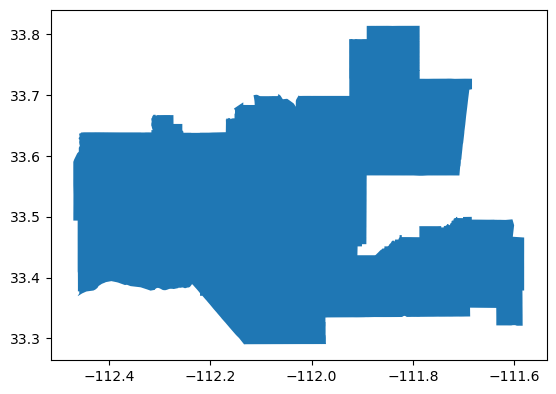

In [60]:
phoenix.plot()


## Clip Rasters to Phoenix, AZ border

First, check CRSs! 

In [255]:
# Check if 2020 and 2017 rasters CRSs match 
assert raster2020.rio.crs == raster2020.rio.crs

In [256]:
# Change Border CRS to match the rasters CRS 
phoenix = phoenix.to_crs(raster2020.rio.crs)

In [ ]:
# Double check if Border and raster CRSs match 
assert raster2020.rio.crs == phoenix.crs

Clip the rasters to the Phoenix's borders using `.rio.clip_box` and `.rio.clip`. 

`clip_box` clips the rasters to the bounding box of Phoenix. Whereas, `clip` acts as a cookie cutter, and cuts the raster to the shape of Phoenix. Lastly, `*` unpacks all the details from the total_bounds such as the xmin, xmax, ymin, and ymax. 

In [257]:
# Clip raster to Phoenix 
raster2020_clip = (raster2020.rio.clip_box(*phoenix.total_bounds)
                   .rio.clip(phoenix.geometry))

raster2017_clip = (raster2017.rio.clip_box(*phoenix.total_bounds)
                   .rio.clip(phoenix.geometry))

RasterioIOError: Read failed. See previous exception for details.

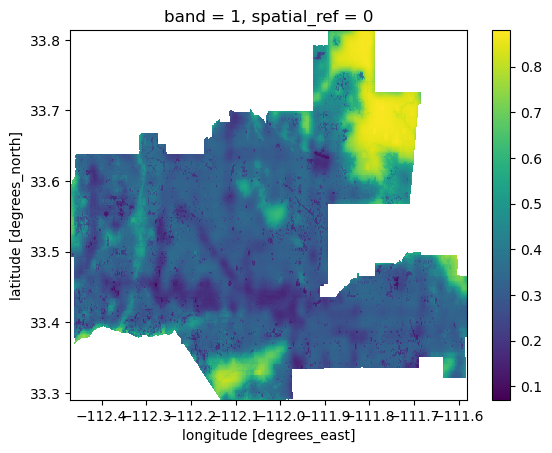

In [ ]:
# Plot the clipped 2017 BII raster 
raster2017_clip.sel(band=1).plot.imshow()

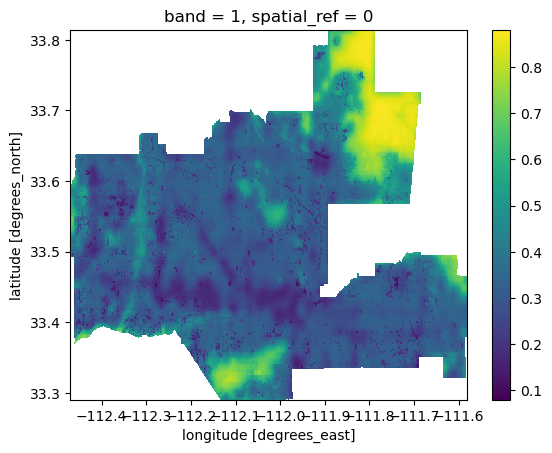

In [ ]:
# Plot the clipped 2020 BII raster 
raster2020_clip.sel(band=1).plot.imshow()

## Calculate the Percentage of Area with BII of at least 0.75 

Find the **percent of area** by 

(1) Finding number of cells greater than or equal to 0.75 (number of 'TRUEs') in each clipped raster. 

(2) Finding number of *total*  cells in each clipped raster (number of 'TRUEs' and 'FALSEs').

(3) Divide part 1 / part 2 = percent of area with BII measurements greater than 0.75 

### Part 1: Find number of cells with a BII measurement greater than or equal to 0.75

Create a dataXarray of Boolean operators that are labled:

-  'TRUE' if greater than or equal than 0.75 

-  'FALSE' if less than 0.75. 

In [ ]:
# Mask of Boolean Operators 
raster2020_cal = raster2020_clip >= 0.75
raster2017_cal = raster2017_clip >= 0.75

Find number of cells that are 'TRUE' with `count_nonzero`.

In [270]:
# Find number of cells = TRUE 
true_2020 = np.count_nonzero(raster2020_cal)
true_2017 = np.count_nonzero(raster2017_cal)

print(true_2020)
print(true_2017)

21986
24133


### Part 2: Find number of *total* cells in clipped raster 

In [ ]:
# Find number of total cells  
raster_count = raster2020_clip.size

# ANOTHER METHOD: print(raster2020_cal.count())

577170

### Part 3: Find percent area 

% area = (number of cells >= 0.75) / (total cells) * 100

In [278]:
# Area Percent  
print(f"Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017: {round((true_2017/raster_count) * 100, 2)}%")
print(f"Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020: {round((true_2020/raster_count) * 100, 2)}%")


Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017: 4.18%
Percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2020: 3.81%


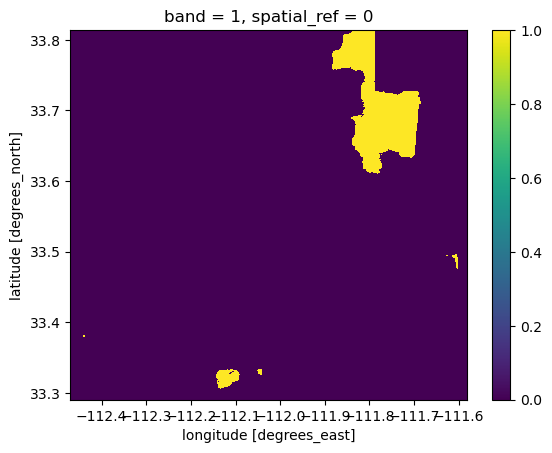

In [ ]:
# Look at rasters of boolean operators (showing if 2017 BII measurements are >= 0.75 or not)
raster2017_cal.plot()

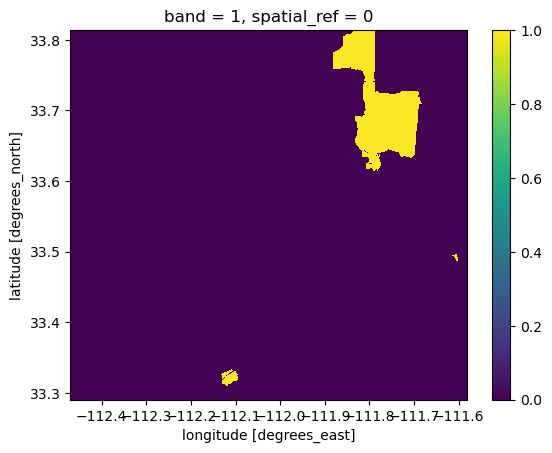

In [268]:
# Look at rasters of boolean operators (showing if 2020 BII measurements are >= 0.75 or not)
raster2020_cal.plot()

## Area with BII>=0.75 in 2017 that was lost by 2020

Find the difference between BII measurements (that are >= 0.75) in 2017 and 2020. 

Change the Boolean operators to 0s and 1s by using `astype`.

-  '1' if greater than or equal than 0.75 

-  '0' if less than 0.75. 

In [ ]:
# Change Boolean operators to 1s and 0s 
raster2020_int = raster2020_cal.astype(int)
raster2017_int = raster2017_cal.astype(int)

Subtract the 2017 and 2020 rasters of 0s (not >= 0.75) and 1s (>= 0.75) to find where there's a difference between the years. 

Values in 'difference' xarray.DataArray mean: 

-  1: loss in biodiversity

-  0: no change in biodiversity

-  -1: gain in biodiversity

In [ ]:
# Find difference between 2020 and 2017 
difference = raster2017_int - raster2020_int

Locations with a biodiversity difference will have a subtraction value of 1 (loss of Biodiveristy) or -1 (gain of biodiversity). With an increase of urbanization in Phoenix, AZ, there will predominantly be a loss of BII (values of 1) between 2017 and 2020. With `.where`, we are keeping all values that are not 0, to eliminate the locations with no BII change. 

In [269]:
#  Keep location with BII chaneg 
difference_na = difference.where(difference != 0)


In [294]:
type(difference_na)

xarray.core.dataarray.DataArray

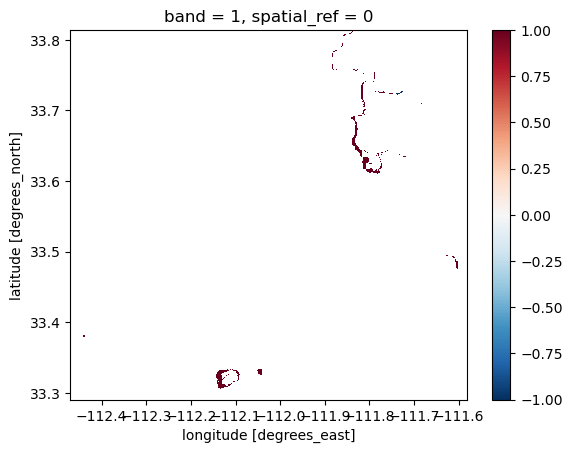

In [ ]:
# Plot the difference in BII measurements from 2017 to 2020
difference_na.plot()

Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.

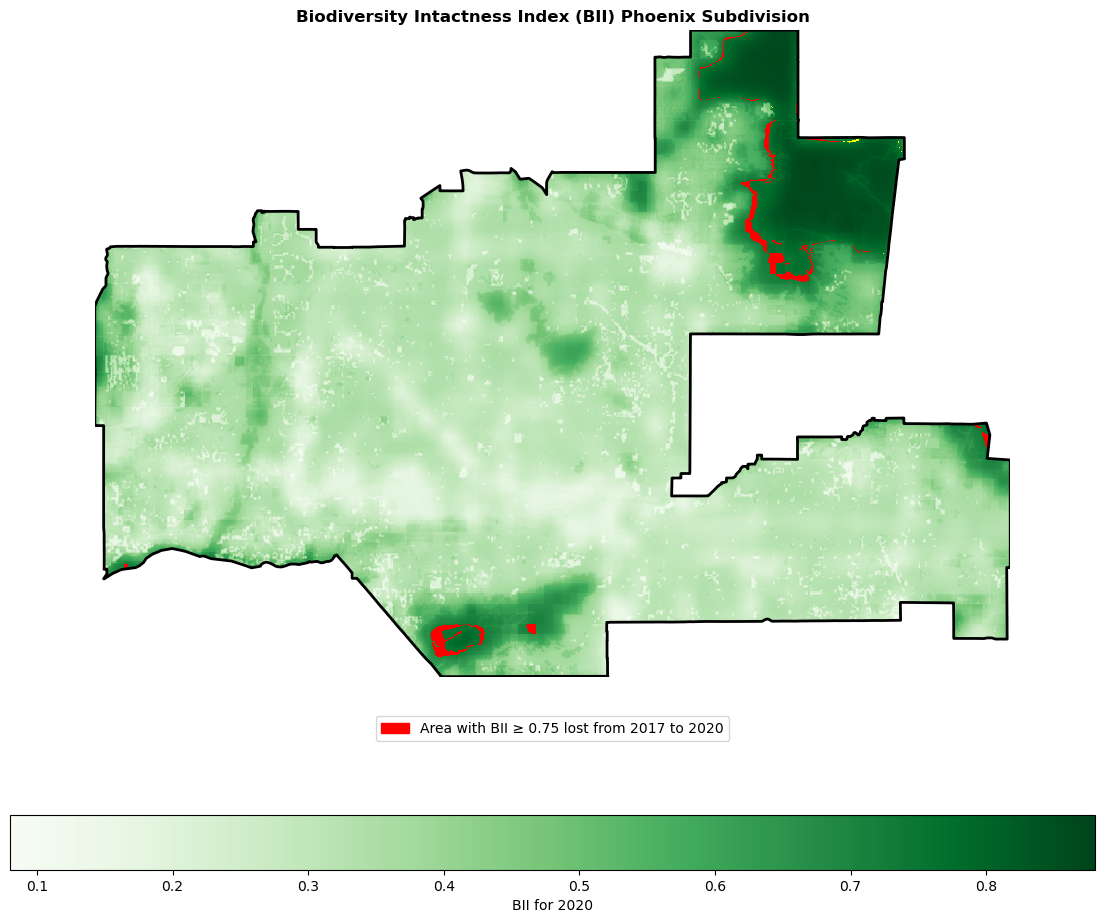

In [300]:
# Plot of 2020 with changes from 2017 
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# No axis 
ax.axis('off')

# Add BII 2020 raster 
raster2020_clip.plot(ax = ax, 
                     cbar_kwargs = {'location': 'bottom', 'label':'BII for 2020'}, 
                     cmap = "Greens")

# Add the 2017-2020 BII >= 0.75 difference 
difference_na.plot(ax = ax, 
                   cmap = 'autumn_r',
                   add_colorbar = False
                    )

# Add border line 
phoenix.plot(ax = ax,   
             edgecolor = 'black', 
             facecolor='none', 
             linewidth= 2)

# Add legend for the difference 
legend_elements = [mpatches.Patch(facecolor='red', edgecolor='r',
                         label='Area with BII ≥ 0.75 lost from 2017 to 2020')]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)

# Title 
ax.set_title("Biodiversity Intactness Index (BII) Phoenix Subdivision", fontweight = 'bold')

plt.show()